/tmp/ipykernel_1034827/1766513188.py:15: RuntimeWarning: invalid value encountered in reciprocal
  H = (1 - ejw) ** (N - L) * (1 - ejw ** D) ** L
/tmp/ipykernel_1034827/1766513188.py:24: RuntimeWarning: divide by zero encountered in log10
  H1_L2_db = 20 * np.log10(np.abs(H1_L2))


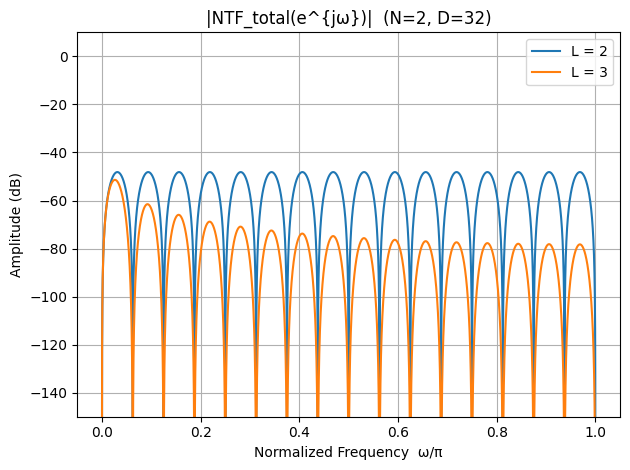

In [1]:
# cic实际未下采样
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

# -------- 参数设置 --------
N = 2   # ΔΣ 调制器阶数
L = 3   # CIC(=sinc^N) 的阶数
D = 32  # 差分延迟/抽取倍率（常记为 R）
worN = 1000000  # 频率采样点数

def ntf_total_response_analytic(N, L, D, worN=4096, whole=False):
    w = np.linspace(0, (2 if whole else 1) * np.pi, worN, endpoint=False)
    ejw = np.exp(-1j * w)
    H = (1 - ejw) ** (N - L) * (1 - ejw ** D) ** L
    H = H / D ** L
    return w, H

# Calculate the responses for L=2 and L=3
w1, H1_L2 = ntf_total_response_analytic(N, 2, D, worN=worN, whole=False)
w1, H1_L3 = ntf_total_response_analytic(N, 3, D, worN=worN, whole=False)

# Convert to dB
H1_L2_db = 20 * np.log10(np.abs(H1_L2))
H1_L3_db = 20 * np.log10(np.abs(H1_L3))

# Plotting
plt.ylim(-150, 10)
plt.plot(w1 / np.pi, H1_L2_db, label="L = 2")
plt.plot(w1 / np.pi, H1_L3_db, label="L = 3")

plt.xlabel("Normalized Frequency  ω/π")
plt.ylabel("Amplitude (dB)")
plt.title(f"|NTF_total(e^{{jω}})|  (N={N}, D={D})")
plt.grid(True, which="both")
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_1034827/3770790789.py:15: RuntimeWarning: invalid value encountered in reciprocal
  H = (1 - ejw) ** (N - L) * (1 - ejw ** D) ** L


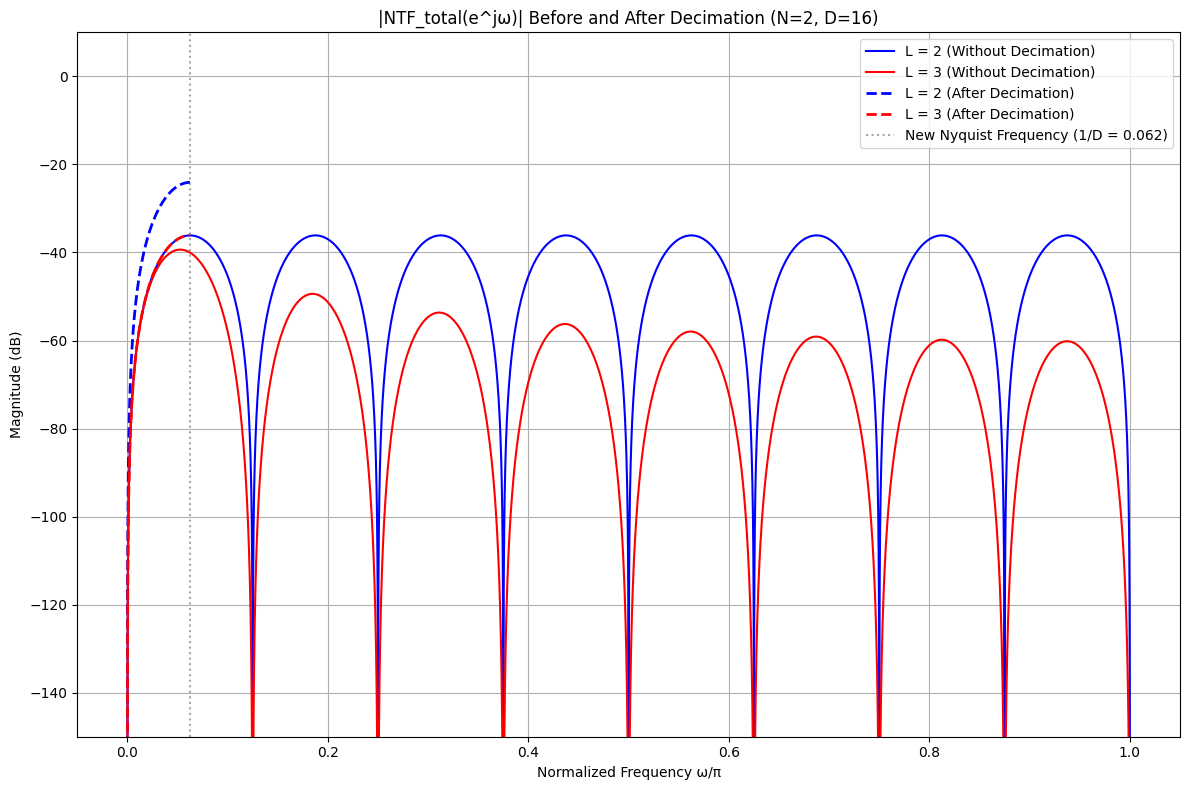

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

# -------- Parameter Settings --------
N = 2   # ΔΣ modulator order
L = 3   # CIC(=sinc^N) order
D = 16  # Differential delay/decimation ratio (often denoted as R)
worN = 100000  # Frequency sampling points

def ntf_total_response_analytic(N, L, D, worN=4096, whole=False):
    """Frequency response of CIC without decimation"""
    w = np.linspace(0, (2 if whole else 1) * np.pi, worN, endpoint=False)
    ejw = np.exp(-1j * w)
    H = (1 - ejw) ** (N - L) * (1 - ejw ** D) ** L
    H = H / D ** L
    return w, H

def ntf_total_response_with_decimation_corrected(N, L, D, worN=4096):
    """CORRECTED: CIC frequency response considering decimation with proper spectral folding"""
    # Original frequency response without decimation
    w_original, H_original = ntf_total_response_analytic(N, L, D, worN=worN, whole=True)
    
    # Frequency axis after decimation (0 to π corresponds to new Nyquist frequency)
    w_decimated = np.linspace(0, np.pi, worN, endpoint=False)
    
    # Calculate spectral folding effect - CORRECTED VERSION
    # For noise, we need to add POWER, not amplitude
    H_decimated_power = np.zeros(worN)
    
    for k in range(D):
        # Calculate frequency position for each mirror component
        w_shifted = (w_decimated + 2 * np.pi * k) / D
        
        # Find the magnitude at each shifted frequency
        # We need to interpolate the magnitude squared (power)
        H_magnitude_squared = np.interp(w_shifted, w_original, np.abs(H_original)**2)
        
        # Accumulate power from all mirror components
        H_decimated_power += H_magnitude_squared
    
    # Convert back to amplitude (square root of power)
    H_decimated_amplitude = np.sqrt(H_decimated_power)
    
    return w_decimated, H_decimated_amplitude

# Calculate frequency responses for different cases
# 1. Without decimation (original response)
w_original, H_original_L2 = ntf_total_response_analytic(N, 2, D, worN=worN, whole=False)
w_original, H_original_L3 = ntf_total_response_analytic(N, 3, D, worN=worN, whole=False)

# 2. After decimation (considering spectral folding) - CORRECTED
w_decimated, H_decimated_L2 = ntf_total_response_with_decimation_corrected(N, 2, D, worN=worN)
w_decimated, H_decimated_L3 = ntf_total_response_with_decimation_corrected(N, 3, D, worN=worN)

# Convert to dB
H_original_L2_db = 20 * np.log10(np.maximum(np.abs(H_original_L2), 1e-10))
H_original_L3_db = 20 * np.log10(np.maximum(np.abs(H_original_L3), 1e-10))
H_decimated_L2_db = 20 * np.log10(np.maximum(H_decimated_L2, 1e-10))
H_decimated_L3_db = 20 * np.log10(np.maximum(H_decimated_L3, 1e-10))

# Plot combined figure
plt.figure(figsize=(12, 8))

# Plot original and decimated responses on the same plot
plt.plot(w_original / np.pi, H_original_L2_db, 'b-', label="L = 2 (Without Decimation)")
plt.plot(w_original / np.pi, H_original_L3_db, 'r-', label="L = 3 (Without Decimation)")

# Plot decimated responses
plt.plot(w_decimated / np.pi / D, H_decimated_L2_db, 'b--', linewidth=2, label="L = 2 (After Decimation)")
plt.plot(w_decimated / np.pi / D, H_decimated_L3_db, 'r--', linewidth=2, label="L = 3 (After Decimation)")

# Add new Nyquist frequency marker
plt.axvline(x=1/D, color='gray', linestyle=':', alpha=0.7, label=f'New Nyquist Frequency (1/D = {1/D:.3f})')

# Labels, title, and legend
plt.ylim(-150, 10)
plt.xlabel("Normalized Frequency ω/π")
plt.ylabel("Magnitude (dB)")
plt.title(f"|NTF_total(e^jω)| Before and After Decimation (N={N}, D={D})")
plt.grid(True, which="both")
plt.legend()

plt.tight_layout()
plt.show()
